In [1]:
# in this series, we are going to build together a quant trading strategy from scratch. 

In [2]:
# lots of feedback that you would like a pratical version of my intro to quant trading video

In [3]:
# code available on github, read the readme and install the libraries

In [4]:
# 3 videos
# y_hat = model(x)
# orders = strategy(y_hat)
# execute(orders)

In [5]:
# Want part two? Please like and subscribe to let me know! And please leave a comment


In [6]:
# build a regression model to predict BTCUSD -> future log return 


# why BTCUSDT -logistic reason (Public API,Orderbook,DMA)
# clone and experiment - this is just a foundation to build upon



In [7]:
# it doesn't matter what exactly we we are trading here
# what i teach in this video is the technical and research methodology needed to build your own model for any asset
# so dont it's just only applicable for BTCUSDT

In [8]:
# this is just a foundation to build upon

In [9]:
# assumes level of programming experience
# don't worry if you don't need have programming experience
# making a machine learning series where you learn python and  machine learning at the same time.


# import all libs

In [10]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


In [11]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [12]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

# Research Parameters

In [13]:
# Trading pair symbol
sym = 'BTCUSDT'
# Historical data window in days (e.g., 6 months)            
hist_data_window = 7 * 4 * 7
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)


# download trade feeds

## Explain columns

In [14]:
binance.download_trades(sym, hist_data_window)


In [15]:
ts = research.load_ohlc_timeseries(sym,  time_interval)
ts

Loading BTCUSDT: 100%|██████████| 345/345 [00:42<00:00,  8.06file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4


# Create Time Series

### Aggregate data into a regular time series

In [16]:
research.load_timeseries(sym, time_interval, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 345/345 [00:34<00:00, 10.01file/s]


datetime,price_median
datetime[μs],f64
2024-10-29 00:00:00,69848.5
2024-10-29 01:00:00,69969.0
2024-10-29 02:00:00,71180.1
2024-10-29 03:00:00,71170.5
2024-10-29 04:00:00,71029.3
…,…
2025-10-08 19:00:00,123402.0
2025-10-08 20:00:00,123340.0
2025-10-08 21:00:00,123098.6


# show static plot of time series

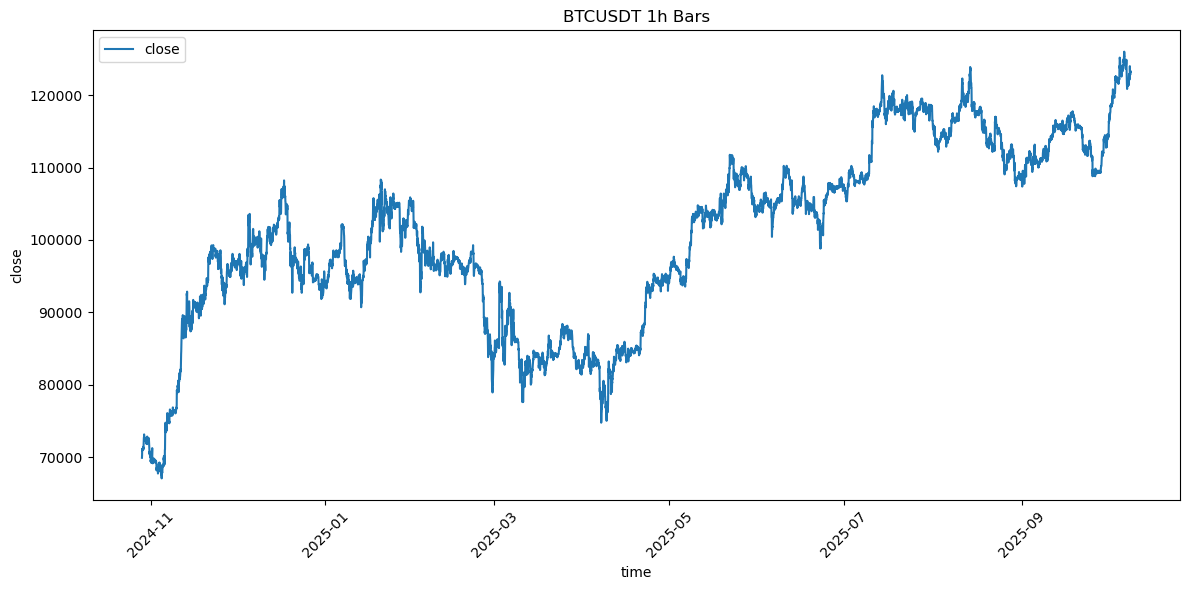

In [17]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)

# dynamic interactive plot of time series

In [18]:

alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

# Feature Engineering

## Create Target - Log Return

In [19]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [20]:
price_time_series = price_time_series.with_columns([
    pl.col('price').diff().alias('price_delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('price_return'),
    ((pl.col('price')/pl.col('price').shift())).log().alias('price_log_return'),
])
price_time_series

price,price_delta,price_return,price_log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


## Create features and lagged features

In [21]:
ts = ts.with_columns(
    (pl.col('close') / pl.col('close').shift(forecast_horizon)).log().alias('close_log_return')
)

In [22]:
target = 'close_log_return'
lr = pl.col('close_log_return')
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias('close_log_return_lag_1'),
    lr.shift(forecast_horizon * 2).alias('close_log_return_lag_2'),
    lr.shift(forecast_horizon * 3).alias('close_log_return_lag_3'),
    lr.shift(forecast_horizon * 4).alias('close_log_return_lag_4'),
)
ts.select(['datetime','close_log_return','close_log_return_lag_1','close_log_return_lag_2','close_log_return_lag_3','close_log_return_lag_4'])

datetime,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,null,null,null,null,null
2024-10-29 01:00:00,0.004956,null,null,null,null
2024-10-29 02:00:00,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…
2025-10-08 19:00:00,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [23]:
ts = research.add_lags(ts, 'close_log_return', max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [24]:
ts.drop_nulls()

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [25]:
research.plot_distribution(ts, 'close_log_return', no_bins = 100)

alt.Chart(...)

In [26]:
research.plot_distribution(ts, 'close', no_bins=100)

alt.Chart(...)

# Build Model

In [27]:
# Simple Linear Model
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)  # Single output (return prediction)
    
    def forward(self, x):
        return self.linear(x)


## Complexity

In [28]:
# Create models for comparison
input_features = 1  # Example: using 2 lag features

linear_model = LinearModel(input_features)


# Print parameter counts
research.print_model_info(linear_model, "Linear Model")
# Show the dramatic difference in complexity
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [29]:
# y = w * x + b

## Splitting data by time

In [30]:
ts = ts.drop_nulls()

In [31]:
# training params
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.2

In [32]:
len(ts)

8275

In [33]:
int(len(ts) * test_size)

1655

In [34]:
# Train/test timeseries split
split_idx = int(len(ts) * (1-test_size))
split_idx

6620

In [35]:
len(ts)

8275

In [36]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [37]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-07-31 20:00:00,116718.9,116927.8,116380.0,116450.0,-0.002306,-0.007521,-0.000953,-0.006604,0.001966
2025-07-31 21:00:00,116450.1,116846.1,116157.1,116479.0,0.000249,-0.002306,-0.007521,-0.000953,-0.006604
2025-07-31 22:00:00,116478.9,116479.0,115934.8,115934.9,-0.004682,0.000249,-0.002306,-0.007521,-0.000953


In [38]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 01:00:00,115366.9,115547.2,114525.0,115270.2,-0.000839,-0.00286,-0.002052,-0.004682,0.000249
2025-08-01 02:00:00,115270.0,115958.1,115159.6,115908.8,0.005525,-0.000839,-0.00286,-0.002052,-0.004682
2025-08-01 03:00:00,115908.7,116000.0,115557.0,115595.7,-0.002705,0.005525,-0.000839,-0.00286,-0.002052
2025-08-01 04:00:00,115595.6,115658.0,115208.7,115648.3,0.000455,-0.002705,0.005525,-0.000839,-0.00286
2025-08-01 05:00:00,115648.4,115873.4,115313.3,115511.4,-0.001184,0.000455,-0.002705,0.005525,-0.000839
…,…,…,…,…,…,…,…,…,…
2025-10-08 19:00:00,123389.8,123690.0,123095.0,123381.8,-0.000065,-0.004816,0.007981,0.007015,-0.00105
2025-10-08 20:00:00,123381.8,123671.5,122757.5,122784.6,-0.004852,-0.000065,-0.004816,0.007981,0.007015
2025-10-08 21:00:00,122784.6,123272.2,122739.7,123231.4,0.003632,-0.004852,-0.000065,-0.004816,0.007981


In [39]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [40]:
y_train

tensor([-0.0007,  0.0030, -0.0031,  ..., -0.0047, -0.0021, -0.0029])

In [41]:
y_test

tensor([-0.0008,  0.0055, -0.0027,  ...,  0.0036, -0.0009,  0.0009])

In [42]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[-0.0008],
        [ 0.0055],
        [-0.0027],
        ...,
        [ 0.0036],
        [-0.0009],
        [ 0.0009]])

In [43]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0007],
        [ 0.0030],
        [-0.0031],
        ...,
        [-0.0047],
        [-0.0021],
        [-0.0029]])

In [44]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 0.0019],
         [-0.0007],
         [ 0.0030],
         ...,
         [ 0.0002],
         [-0.0047],
         [-0.0021]]),
 tensor([[-0.0029],
         [-0.0008],
         [ 0.0055],
         ...,
         [-0.0049],
         [ 0.0036],
         [-0.0009]]),
 tensor([[-0.0007],
         [ 0.0030],
         [-0.0031],
         ...,
         [-0.0047],
         [-0.0021],
         [-0.0029]]),
 tensor([[-0.0008],
         [ 0.0055],
         [-0.0027],
         ...,
         [ 0.0036],
         [-0.0009],
         [ 0.0009]]))

In [45]:
# Training: X_train -> model -> y_train
# Testing: X_test -> model -> y_test

In [46]:
X_train

tensor([[ 0.0019],
        [-0.0007],
        [ 0.0030],
        ...,
        [ 0.0002],
        [-0.0047],
        [-0.0021]])

In [47]:
X_train.shape

torch.Size([6620, 1])

In [48]:
y_train

tensor([[-0.0007],
        [ 0.0030],
        [-0.0031],
        ...,
        [-0.0047],
        [-0.0021],
        [-0.0029]])

In [49]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0007],
        [ 0.0030],
        [-0.0031],
        ...,
        [-0.0047],
        [-0.0021],
        [-0.0029]])

In [50]:
y_train.shape

torch.Size([6620, 1])

In [51]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[-0.0008],
        [ 0.0055],
        [-0.0027],
        ...,
        [ 0.0036],
        [-0.0009],
        [ 0.0009]])

In [52]:
y_test.shape

torch.Size([1655, 1])

In [53]:
X_train,X_test,y_train,y_test = research.timeseries_train_test_split(ts, features, target, test_size)

### Batch Gradient Descent

In [54]:
# Hyperparamters
no_epochs = 1000 * 8
lr = 0.0005

# create model (Kaiming uniform)
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimization algo
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
print("\nTraining model...")

# main learning loop
for epoch in range(no_epochs):
    # Forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # Backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # Check for improvement
    train_loss = loss.item()

    # Logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {loss.item():.6f}")


# After training
print("\nLearned parameters:")

# print out our learned params
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f'\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}')


Training model...
Epoch [500/8000], Loss: 0.468840
Epoch [1000/8000], Loss: 0.234608
Epoch [1500/8000], Loss: 0.101737
Epoch [2000/8000], Loss: 0.036158
Epoch [2500/8000], Loss: 0.009766
Epoch [3000/8000], Loss: 0.001829
Epoch [3500/8000], Loss: 0.000230
Epoch [4000/8000], Loss: 0.000040
Epoch [4500/8000], Loss: 0.000028
Epoch [5000/8000], Loss: 0.000027
Epoch [5500/8000], Loss: 0.000027
Epoch [6000/8000], Loss: 0.000027
Epoch [6500/8000], Loss: 0.000027
Epoch [7000/8000], Loss: 0.000027
Epoch [7500/8000], Loss: 0.000027
Epoch [8000/8000], Loss: 0.000027

Learned parameters:
linear.weight:
[[-0.02233966]]
linear.bias:
[7.4847216e-05]

Test Loss: 0.000011, Train Loss: 0.000027


## Test trading performance

In [55]:

trade_results = pl.DataFrame({
    'y_hat':y_hat.squeeze(),
    'y':y_test.squeeze()}
).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal')
).with_columns((pl.col('signal')*pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000139,-0.000839,false,1.0,-0.000839,-0.000839
0.000094,0.005525,true,1.0,0.005525,0.004686
-0.000049,-0.002705,true,-1.0,0.002705,0.007391
0.000135,0.000455,true,1.0,0.000455,0.007846
0.000065,-0.001184,false,1.0,-0.001184,0.006662
…,…,…,…,…,…
0.000182,-0.000065,false,1.0,-0.000065,0.060621
0.000076,-0.004852,false,1.0,-0.004852,0.055769
0.000183,0.003632,true,1.0,0.003632,0.059401


In [56]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [57]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log'),
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000139,-0.000839,false,1.0,-0.000839,-0.000839,0.0
0.000094,0.005525,true,1.0,0.005525,0.004686,0.0
-0.000049,-0.002705,true,-1.0,0.002705,0.007391,0.0
0.000135,0.000455,true,1.0,0.000455,0.007846,0.0
0.000065,-0.001184,false,1.0,-0.001184,0.006662,-0.001184
…,…,…,…,…,…,…
0.000182,-0.000065,false,1.0,-0.000065,0.060621,-0.044263
0.000076,-0.004852,false,1.0,-0.004852,0.055769,-0.049115
0.000183,0.003632,true,1.0,0.003632,0.059401,-0.045483


In [58]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.1251072883605957

In [59]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.11759777398237603)

In [60]:
equity_peak = 1000 
equity_peak * drawdown_pct 

np.float64(-117.59777398237603)

In [61]:
win_rate = trade_results['is_won'].mean()
win_rate

0.4984894259818731

In [62]:
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000139,-0.000839,false,1.0,-0.000839,-0.000839,0.0
0.000094,0.005525,true,1.0,0.005525,0.004686,0.0
-0.000049,-0.002705,true,-1.0,0.002705,0.007391,0.0
0.000135,0.000455,true,1.0,0.000455,0.007846,0.0
0.000065,-0.001184,false,1.0,-0.001184,0.006662,-0.001184
…,…,…,…,…,…,…
0.000182,-0.000065,false,1.0,-0.000065,0.060621,-0.044263
0.000076,-0.004852,false,1.0,-0.004852,0.055769,-0.049115
0.000183,0.003632,true,1.0,0.003632,0.059401,-0.045483


In [63]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss 
ev

3.695478841621888e-05

In [64]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.061160169541835785

In [65]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.0630691718539806)

In [66]:
1000*compound_return

np.float64(1063.0691718539806)

In [67]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.02022363804280758

In [68]:
equity_peak = trade_results['equity_curve'].max()

In [69]:
# not measuring risk here - best here is risk-adjsuted returns

In [70]:
std = trade_results['trade_log_return'].std()
std

0.003276991192251444

In [71]:
std_trade_log_return = trade_results['trade_log_return'].std()
sharpe = ev / std_trade_log_return * annualized_rate # sqrt of no trading periods
sharpe

np.float64(1.0554739014890244)

In [72]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 1655,
 'win_rate': 0.4984894259818731,
 'avg_win': 0.002236606398973753,
 'avg_loss': -0.0021494459088247033,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.02237566001713276,
 'ev': 3.695478841621888e-05,
 'std': 0.003276991192251444,
 'total_log_return': 0.061160169541835785,
 'compound_return': np.float64(1.0630691718539806),
 'max_drawdown': -0.1251072883605957,
 'equity_trough': -0.02022363804280758,
 'equity_peak': 0.10488364845514297,
 'sharpe': np.float64(1.0554739014890233)}

In [73]:
# research.eval_model_performance(y_test, y_hat, feature_cols, target_col, annulized_rate)

In [74]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model.apply(research.init_weights)
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2069,
 'win_rate': 0.5200579990333495,
 'avg_win': 0.0022360760305761584,
 'avg_loss': -0.0022476966211554214,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.019244860857725143,
 'ev': 8.412521222455932e-05,
 'std': 0.0032799625769257545,
 'total_log_return': 0.17405502498149872,
 'compound_return': np.float64(1.190121050407482),
 'max_drawdown': -0.19355052709579468,
 'equity_trough': -0.05015525966882706,
 'equity_peak': 0.2147214114665985,
 'sharpe': np.float64(2.4005421575373638),
 'weights': '[-0.02715509]',
 'biases': '7.828840898582712e-05'}

In [75]:
import itertools


target = 'close_log_return'
benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))
# combos += list(itertools.combinations(feature_pool, 2))
for features in combos:
    model = LinearModel(len(features))
    model.apply(research.init_weights)
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_2""","""close_log_return""",2069,0.520058,0.002236,-0.002248,0.029018,-0.019245,0.000084,0.00328,0.174055,1.190121,-0.193551,-0.050155,0.214721,2.400542,"""[-0.02715509]""","""7.828840898582712e-05"""
"""close_log_return_lag_3""","""close_log_return""",2069,0.500725,0.002271,-0.002212,0.029018,-0.022376,0.000033,0.003281,0.067902,1.07026,-0.223851,-0.207946,0.067902,0.936232,"""[-0.03213733]""","""8.700583566678688e-05"""
"""close_log_return_lag_1""","""close_log_return""",2069,0.496858,0.002277,-0.002207,0.029018,-0.022376,0.000021,0.003281,0.043191,1.044138,-0.179317,-0.022707,0.198221,0.595506,"""[-0.07195645]""","""9.381295240018517e-05"""
"""close_log_return_lag_4""","""close_log_return""",2069,0.499275,0.002259,-0.002224,0.029018,-0.022376,0.000014,0.003281,0.029914,1.030366,-0.142968,-0.107926,0.051971,0.412434,"""[-0.00176126]""","""7.380719762295485e-05"""


In [76]:
research.auto_reg_corr_matrx(ts, 'close_log_return', max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,-0.020392,0.00368,-0.023582,0.007602
-0.020392,1.0,-0.02042,0.003779,-0.023516
0.00368,-0.02042,1.0,-0.020618,0.003669
-0.023582,0.003779,-0.020618,1.0,-0.020215
0.007602,-0.023516,0.003669,-0.020215,1.0


In [77]:
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [171]:
maker_fee = 0.0001
taker_fee = 0.0003
roundtrip_fee_log = np.log(1 - 2 * taker_fee)  # ≈ -0.001501

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias("tx_fee_log"))
model_trades = model_trades.with_columns((pl.col("trade_log_return") + pl.col("tx_fee_log")).alias("trade_log_return_net"))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))
model_trades


y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000562,0.002889,true,1.0,0.002889,0.002889,0.0,-0.0002,0.002689,0.002689,-0.0006,0.002289,0.002289,-0.0006,0.002289,0.002289
0.000288,-0.000739,false,1.0,-0.000739,0.00215,-0.000739,-0.0002,-0.000939,0.00175,-0.0006,-0.001339,0.000949,-0.0006,-0.001339,0.000949
0.000728,0.011195,true,1.0,0.011195,0.013345,0.0,-0.0002,0.010995,0.012745,-0.0006,0.010595,0.011544,-0.0006,0.010595,0.011544
-0.000717,-0.001278,true,-1.0,0.001278,0.014623,0.0,-0.0002,0.001078,0.013823,-0.0006,0.000678,0.012222,-0.0006,0.000678,0.012222
0.000793,-0.0065,false,1.0,-0.0065,0.008123,-0.0065,-0.0002,-0.0067,0.007123,-0.0006,-0.0071,0.005122,-0.0006,-0.0071,0.005122
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.00008,0.003757,false,-1.0,-0.003757,0.122036,-0.003757,-0.0002,-0.003957,0.081632,-0.0006,-0.004357,0.0008,-0.0006,-0.004357,0.0008
0.000183,-0.001858,false,1.0,-0.001858,0.120179,-0.005614,-0.0002,-0.002058,0.079575,-0.0006,-0.002458,-0.001658,-0.0006,-0.002458,-0.001658
0.000863,-0.025324,false,1.0,-0.025324,0.094854,-0.030938,-0.0002,-0.025524,0.05405,-0.0006,-0.025924,-0.027582,-0.0006,-0.025924,-0.027582


In [172]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [173]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [81]:
model_trades['is_won'].mean()

0.5200579990333495

In [82]:
model_trades['trade_log_return'].mean()

8.412521222455924e-05

In [83]:
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000163,0.002625,true,1.0,0.002625,0.002625,0.0,-0.0006,0.002025,0.002025,-0.0002,0.002425,0.002425,-0.0006,0.002025,0.002025
0.000142,0.00175,true,1.0,0.00175,0.004376,0.0,-0.0006,0.00115,0.003175,-0.0002,0.00155,0.003976,-0.0006,0.00115,0.003175
0.000007,-0.001083,false,1.0,-0.001083,0.003293,-0.001083,-0.0006,-0.001683,0.001492,-0.0002,-0.001283,0.002693,-0.0006,-0.001683,0.001492
0.000031,0.000121,true,1.0,0.000121,0.003414,-0.000962,-0.0006,-0.000479,0.001013,-0.0002,-0.000079,0.002614,-0.0006,-0.000479,0.001013
0.000108,-0.001652,false,1.0,-0.001652,0.001762,-0.002614,-0.0006,-0.002252,-0.001239,-0.0002,-0.001852,0.000762,-0.0006,-0.002252,-0.001239
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.000138,-0.000065,true,-1.0,0.000065,0.177034,-0.037687,-0.0006,-0.000535,-1.062338,-0.0002,-0.000135,-0.236007,-0.0006,-0.000535,-1.062338
0.000209,-0.004852,false,1.0,-0.004852,0.172182,-0.042539,-0.0006,-0.005452,-1.06779,-0.0002,-0.005052,-0.241059,-0.0006,-0.005452,-1.06779
0.00008,0.003632,true,1.0,0.003632,0.175814,-0.038907,-0.0006,0.003032,-1.064758,-0.0002,0.003432,-0.237627,-0.0006,0.003032,-1.064758


In [84]:
research.plot_column(model_trades, 'equity_curve_net_maker')

alt.Chart(...)

## Model for Net Returns

In [150]:
# 6h
time_interval = '12h'
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT:   0%|          | 0/345 [00:00<?, ?file/s]

Loading BTCUSDT: 100%|██████████| 345/345 [00:35<00:00,  9.65file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3
…,…,…,…,…
2025-10-06 12:00:00,124161.3,126208.5,124123.3,124628.5
2025-10-07 00:00:00,124628.6,125047.0,123261.6,124397.2
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5


In [174]:
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71440.1,null,null,null,null,null
2024-10-29 12:00:00,71440.0,73660.0,70900.0,72739.5,0.018025,null,null,null,null
2024-10-30 00:00:00,72739.5,72797.4,71931.1,71995.0,-0.010288,0.018025,null,null,null
2024-10-30 12:00:00,71994.9,72984.9,71444.2,72349.0,0.004905,-0.010288,0.018025,null,null
2024-10-31 00:00:00,72349.0,72720.3,72030.5,72213.3,-0.001877,0.004905,-0.010288,0.018025,null
…,…,…,…,…,…,…,…,…,…
2025-10-06 12:00:00,124161.3,126208.5,124123.3,124628.5,0.003757,0.005933,0.000109,0.008708,0.003427
2025-10-07 00:00:00,124628.6,125047.0,123261.6,124397.2,-0.001858,0.003757,0.005933,0.000109,0.008708
2025-10-07 12:00:00,124397.1,125098.0,120516.0,121286.5,-0.025324,-0.001858,0.003757,0.005933,0.000109


In [175]:
test_size = 0.2
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.HuberLoss(), test_size=test_size)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",137,0.540146,0.008184,-0.007501,0.040366,-0.025324,0.000971,0.01067,0.13307,1.14233,-0.076382,-0.024043,0.150988,8.520455,"""[-0.11199906]""","""0.0009569649118930101"""
"""close_log_return_lag_4""","""close_log_return""",137,0.518248,0.008065,-0.00766,0.040366,-0.025324,0.000489,0.010703,0.067039,1.069337,-0.130755,-0.063015,0.078263,4.279203,"""[0.03483207]""","""0.0008318792097270489"""
"""close_log_return_lag_3""","""close_log_return""",137,0.49635,0.007841,-0.007899,0.025288,-0.040366,-0.000086,0.010714,-0.011839,0.98823,-0.132662,-0.109357,0.023305,-0.754953,"""[0.08318467]""","""0.0007807529764249921"""
"""close_log_return_lag_2""","""close_log_return""",137,0.445255,0.008378,-0.007462,0.040366,-0.025324,-0.000409,0.010706,-0.056081,0.945463,-0.11817,-0.072039,0.046131,-3.578595,"""[-0.09579597]""","""0.0009404869051650167"""


In [176]:
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.MSELoss(), test_size=test_size)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",137,0.540146,0.008184,-0.007501,0.040366,-0.025324,0.000971,0.01067,0.13307,1.14233,-0.076382,-0.024043,0.150988,8.520455,"""[-0.11160008]""","""0.0009513355325907469"""
"""close_log_return_lag_4""","""close_log_return""",137,0.525547,0.008031,-0.007691,0.040366,-0.025324,0.000572,0.010699,0.078353,1.081505,-0.119441,-0.051701,0.089577,5.003318,"""[0.0356621]""","""0.0008140580030158162"""
"""close_log_return_lag_3""","""close_log_return""",137,0.49635,0.007841,-0.007899,0.025288,-0.040366,-0.000086,0.010714,-0.011839,0.98823,-0.132662,-0.109357,0.023305,-0.754953,"""[0.08365197]""","""0.0007795332348905504"""
"""close_log_return_lag_2""","""close_log_return""",137,0.445255,0.008378,-0.007462,0.040366,-0.025324,-0.000409,0.010706,-0.056081,0.945463,-0.11817,-0.072039,0.046131,-3.578595,"""[-0.0963412]""","""0.0009412087965756655"""


In [177]:
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.L1Loss(), test_size=test_size)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1""","""close_log_return""",137,0.532847,0.008015,-0.007704,0.040366,-0.025324,0.000672,0.010693,0.092017,1.096383,-0.076382,-0.031479,0.113692,5.879044,"""[-0.11939888]""","""0.0006326499860733747"""
"""close_log_return_lag_3""","""close_log_return""",137,0.525547,0.00809,-0.007626,0.040366,-0.025324,0.000633,0.010695,0.086752,1.090627,-0.111042,-0.043302,0.097976,5.541465,"""[0.03465766]""","""0.0007974263862706721"""
"""close_log_return_lag_4""","""close_log_return""",137,0.518248,0.008065,-0.00766,0.040366,-0.025324,0.000489,0.010703,0.067039,1.069337,-0.130755,-0.063015,0.078263,4.279203,"""[0.0037613]""","""0.0006475209956988692"""
"""close_log_return_lag_2""","""close_log_return""",137,0.452555,0.008181,-0.007613,0.040366,-0.025324,-0.000465,0.010704,-0.06376,0.93823,-0.123804,-0.079718,0.044086,-4.069485,"""[-0.05462365]""","""0.000706715858541429"""


In [178]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.L1Loss(), max_no_features=3, test_size=test_size)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",137,0.547445,0.008328,-0.007316,0.040366,-0.025324,0.001248,0.010641,0.170999,1.18649,-0.050118,-0.045975,0.180366,10.978949,"""[-0.10395038 -0.06726477 0.02827305]""","""0.0006712074973620474"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_4""","""close_log_return""",137,0.540146,0.008271,-0.007398,0.040366,-0.025324,0.001066,0.010661,0.145984,1.157177,-0.0764,-0.024043,0.163902,9.355258,"""[-0.08846962 -0.00808936 -0.03080847]""","""0.0007056649192236364"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",137,0.547445,0.008022,-0.007686,0.040366,-0.025324,0.000913,0.010675,0.125106,1.133268,-0.0764,-0.031479,0.143024,8.006612,"""[-0.11461414 0.0104452 ]""","""0.0006011787918396294"""
"""close_log_return_lag_1,close_log_return_lag_4""","""close_log_return""",137,0.532847,0.008041,-0.007675,0.040366,-0.025324,0.000699,0.010691,0.095813,1.100553,-0.0764,-0.027647,0.117487,6.122569,"""[-0.11983366 -0.01209559]""","""0.0006939729209989309"""
"""close_log_return_lag_1""","""close_log_return""",137,0.532847,0.008015,-0.007704,0.040366,-0.025324,0.000672,0.010693,0.092017,1.096383,-0.076382,-0.031479,0.113692,5.879044,"""[-0.11939888]""","""0.0006326499860733747"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",137,0.532847,0.007745,-0.008012,0.040366,-0.025324,0.000384,0.010707,0.052635,1.054045,-0.071573,-0.070185,0.072794,3.358423,"""[-0.11476061 -0.04553207]""","""0.0008004396804608405"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",137,0.467153,0.008603,-0.007227,0.040366,-0.025324,0.000168,0.010713,0.022986,1.023252,-0.064167,-0.054244,0.059701,1.46584,"""[-0.05782619 0.03911056]""","""0.0007645132718607783"""
"""close_log_return_lag_3,close_log_return_lag_4""","""close_log_return""",137,0.481752,0.007988,-0.00776,0.025288,-0.040366,-0.000173,0.010713,-0.023751,0.976529,-0.144574,-0.121269,0.023305,-1.514648,"""[ 0.05933945 -0.01374813]""","""0.0006282828981056809"""


In [179]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.MSELoss(), max_no_features=3, test_size=test_size)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",137,0.49635,0.009023,-0.006734,0.040366,-0.025324,0.001087,0.010658,0.148899,1.160556,-0.082293,-0.064021,0.166817,9.544014,"""[-0.11407851 0.08383795]""","""0.0008744787191972136"""
"""close_log_return_lag_1,close_log_return_lag_4""","""close_log_return""",137,0.576642,0.007681,-0.008128,0.040366,-0.025324,0.000988,0.010668,0.135387,1.14498,-0.076382,-0.017522,0.153305,8.670074,"""[-0.11197324 0.04180029]""","""0.0009088317165151238"""
"""close_log_return_lag_1""","""close_log_return""",137,0.540146,0.008184,-0.007501,0.040366,-0.025324,0.000971,0.01067,0.13307,1.14233,-0.076382,-0.024043,0.150988,8.520455,"""[-0.11160008]""","""0.0009513355325907469"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_4""","""close_log_return""",137,0.510949,0.008602,-0.007105,0.040366,-0.025324,0.000921,0.010674,0.126112,1.134409,-0.082293,-0.058647,0.14403,8.071507,"""[-0.10935359 0.07886743 0.05441369]""","""0.0008267667726613581"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",137,0.50365,0.008536,-0.007194,0.040366,-0.025324,0.000728,0.010689,0.099778,1.104925,-0.058491,-0.061257,0.113507,6.377102,"""[-0.11784213 -0.10218547 0.06025355]""","""0.0009916048729792237"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""close_log_return_lag_2,close_log_return_lag_4""","""close_log_return""",137,0.445255,0.00881,-0.007115,0.040366,-0.025324,-0.000024,0.010714,-0.003349,0.996657,-0.104536,-0.024043,0.085229,-0.213545,"""[-0.09524632 0.02839795]""","""0.0009114772547036409"""
"""close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4""","""close_log_return""",137,0.452555,0.008607,-0.00726,0.040366,-0.025324,-0.000079,0.010714,-0.010866,0.989193,-0.081028,-0.078531,0.004622,-0.692894,"""[-0.08403858 0.07794005 0.03661826]""","""0.0008272984996438026"""
"""close_log_return_lag_3""","""close_log_return""",137,0.49635,0.007841,-0.007899,0.025288,-0.040366,-0.000086,0.010714,-0.011839,0.98823,-0.132662,-0.109357,0.023305,-0.754953,"""[0.08365197]""","""0.0007795332348905504"""


In [ ]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
research.benchmark_linear_models(ts.drop_nulls(), 'close_log_return', feature_pool, annualized_rate, loss=nn.HuberLoss(), max_no_features=3, test_size=test_size)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",137,0.547445,0.008328,-0.007316,0.040366,-0.025324,0.001248,0.010641,0.170999,1.18649,-0.050118,-0.045975,0.180366,10.978949,"""[-0.10395038 -0.06726477 0.02827305]""","""0.0006712074973620474"""
"""close_log_return_lag_1,close_log_return_lag_3,close_log_return_lag_4""","""close_log_return""",137,0.540146,0.008271,-0.007398,0.040366,-0.025324,0.001066,0.010661,0.145984,1.157177,-0.0764,-0.024043,0.163902,9.355258,"""[-0.08846962 -0.00808936 -0.03080847]""","""0.0007056649192236364"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",137,0.547445,0.008022,-0.007686,0.040366,-0.025324,0.000913,0.010675,0.125106,1.133268,-0.0764,-0.031479,0.143024,8.006612,"""[-0.11461414 0.0104452 ]""","""0.0006011787918396294"""
"""close_log_return_lag_1,close_log_return_lag_4""","""close_log_return""",137,0.532847,0.008041,-0.007675,0.040366,-0.025324,0.000699,0.010691,0.095813,1.100553,-0.0764,-0.027647,0.117487,6.122569,"""[-0.11983366 -0.01209559]""","""0.0006939729209989309"""
"""close_log_return_lag_1""","""close_log_return""",137,0.532847,0.008015,-0.007704,0.040366,-0.025324,0.000672,0.010693,0.092017,1.096383,-0.076382,-0.031479,0.113692,5.879044,"""[-0.11939888]""","""0.0006326499860733747"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",137,0.532847,0.007745,-0.008012,0.040366,-0.025324,0.000384,0.010707,0.052635,1.054045,-0.071573,-0.070185,0.072794,3.358423,"""[-0.11476061 -0.04553207]""","""0.0008004396804608405"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",137,0.467153,0.008603,-0.007227,0.040366,-0.025324,0.000168,0.010713,0.022986,1.023252,-0.064167,-0.054244,0.059701,1.46584,"""[-0.05782619 0.03911056]""","""0.0007645132718607783"""
"""close_log_return_lag_3,close_log_return_lag_4""","""close_log_return""",137,0.481752,0.007988,-0.00776,0.025288,-0.040366,-0.000173,0.010713,-0.023751,0.976529,-0.144574,-0.121269,0.023305,-1.514648,"""[ 0.05933945 -0.01374813]""","""0.0006282828981056809"""


In [170]:

# experiment with different hyperparameters,
# different loss functions, different optimizers

In [93]:
features = ['close_log_return_lag_1']
model = LinearModel(len(features))
model.apply(research.init_weights)
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.L1Loss(), no_epochs=2000, test_size=0.3)
model_trades = research.add_tx_fees(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [94]:
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log_maker,trade_log_return_net_maker,equity_curve_net_maker,tx_fee_log_taker,trade_log_return_net_taker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64
0.000562,0.002889,true,1.0,0.002889,0.002889,0.0,-0.0002,0.002689,0.002689,-0.0006,0.002289,0.002289
0.000288,-0.000739,false,1.0,-0.000739,0.00215,-0.000739,-0.0002,-0.000939,0.00175,-0.0006,-0.001339,0.000949
0.000728,0.011195,true,1.0,0.011195,0.013345,0.0,-0.0002,0.010995,0.012745,-0.0006,0.010595,0.011544
-0.000717,-0.001278,true,-1.0,0.001278,0.014623,0.0,-0.0002,0.001078,0.013823,-0.0006,0.000678,0.012222
0.000793,-0.0065,false,1.0,-0.0065,0.008123,-0.0065,-0.0002,-0.0067,0.007123,-0.0006,-0.0071,0.005122
…,…,…,…,…,…,…,…,…,…,…,…,…
-0.00008,0.003757,false,-1.0,-0.003757,0.122036,-0.003757,-0.0002,-0.003957,0.081632,-0.0006,-0.004357,0.0008
0.000183,-0.001858,false,1.0,-0.001858,0.120179,-0.005614,-0.0002,-0.002058,0.079575,-0.0006,-0.002458,-0.001658
0.000863,-0.025324,false,1.0,-0.025324,0.094854,-0.030938,-0.0002,-0.025524,0.05405,-0.0006,-0.025924,-0.027582


In [95]:
research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [96]:
research.plot_column(model_trades, 'equity_curve_net_maker')

alt.Chart(...)

In [97]:
torch.save(model.state_dict(), 'model_weights.pth')

In [98]:
# how to use a modern machine learning library - pytorch
# dont focus on the win rate - Either you have a high win rate OR you're a bad trader
# measure AS MUCH AS POSSIBLE
# this is just a foundation to build upon: 
    # increase the model complexity, 
    # create new features
    # use a rolling window to train models

# next video is we are going to build a strategy around this model

# please like and subscribe as this is the only feedback signal i have if you want more content

# Video 2 - Strategy

In [99]:
# 1. Entry/exit timing
# 2. position size
# 3. should we use take-profit orders?
# 4. should we use stop-loss orders?

# the key metric is we want to increase the expected value of our trade?

In [100]:
sym = 'BTCUSDT'
time_interval = '8h'
forecast_horizon = 1
test_size = 0.25

### load our model from the previous video

In [101]:
import models
model = models.LinearModel(1)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [102]:
research.print_model_params(model)

linear.weight:
[[-0.12107985]]
linear.bias:
[0.00063802]


In [103]:
def model(x):
    w = -0.09911217
    b = 0.00059838
    return w * x + b

### Mean Reversion Model

In [104]:
series = [-0.010000, 0.013399, -0.012212, 0.01197, -0.01242, 0.00927]
mu = np.mean(series)
mean_reversion_df = pl.DataFrame({'log_return': series, 'mean': mu})
mean_reversion_df[['log_return','mean']]

log_return,mean
f64,f64
-0.01,0.000001
0.013399,0.000001
-0.012212,0.000001
0.01197,0.000001
-0.01242,0.000001
0.00927,0.000001


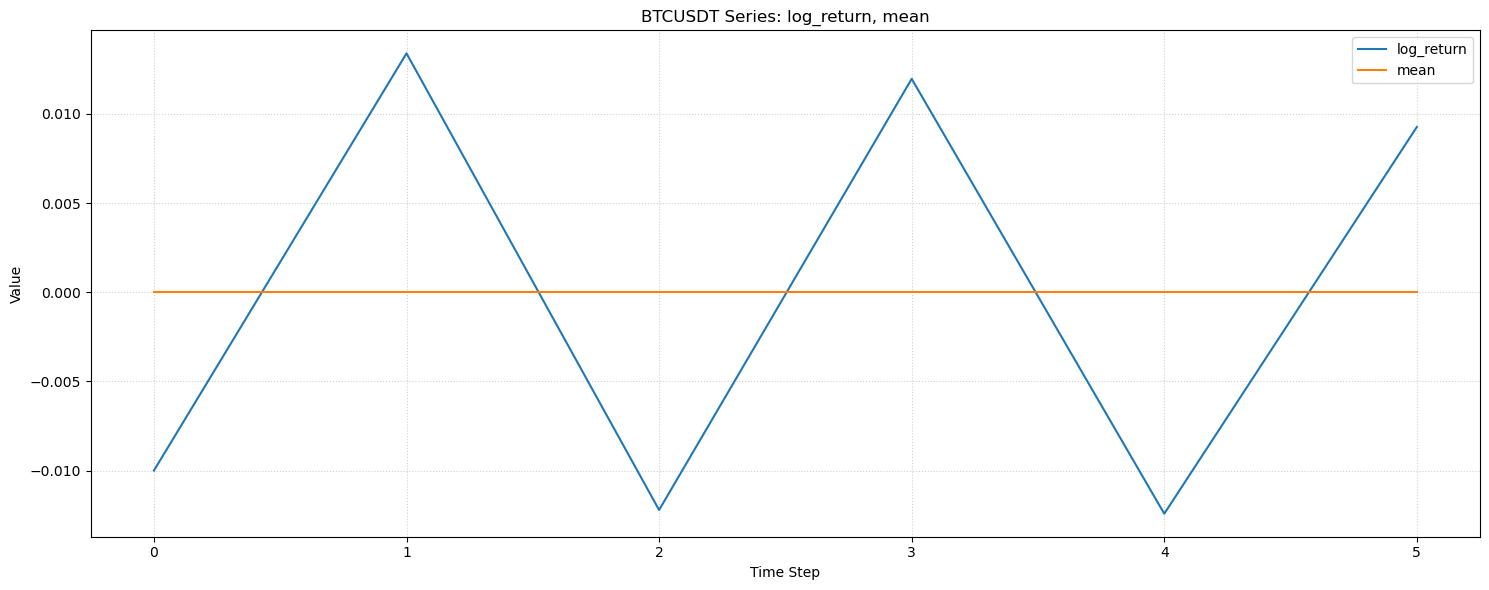

In [105]:
from typing import List

research.plot_multiple_lines(mean_reversion_df, ['log_return','mean'], sym)

### load time series data

In [106]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 345/345 [00:34<00:00, 10.09file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8
…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4


### add log return target and it's lags

In [107]:
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=1)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824
…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129


### time split the time series

In [108]:
train_trades, test_trades = research.timeseries_split(ts, test_size)
train_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,71607.0,69733.0,71004.2,null,null
2024-10-29 08:00:00,71004.1,72490.0,70900.0,72374.9,0.019121,null
2024-10-29 16:00:00,72374.9,73660.0,71871.1,72739.5,0.005025,0.019121
2024-10-30 00:00:00,72739.5,72797.4,72018.0,72244.8,-0.006824,0.005025
2024-10-30 08:00:00,72244.8,72620.0,71444.2,72058.8,-0.002578,-0.006824
…,…,…,…,…,…,…
2025-07-13 00:00:00,117389.4,118040.8,117164.3,117950.0,0.004765,0.002676
2025-07-13 08:00:00,117950.0,119655.0,117641.3,118610.6,0.005585,0.004765
2025-07-13 16:00:00,118610.6,119454.9,118197.7,119038.3,0.003599,0.005585


In [109]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1
datetime[μs],f64,f64,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494
…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129


### Timing

In [110]:
# 00:00 -> trade to create a BTCUSDT position based on our prediction
# 08:00 -> trade to close the existing BTCUSDT position, trade to enter a new position on the current log return (00:00 -> 08:00) prediction
# 16:00 -> trade to close the existing BTCUSDT pos, trade to enter a new position on the current log return (08:00 -> 16:00) prediction

In [111]:
X_train, X_test, y_train, y_test = research.timeseries_train_test_split(ts, ['close_log_return_lag_1'], 'close_log_return', test_size)

In [112]:
y_hat = model(X_test)


In [113]:
y_hat = y_hat.detach().numpy()
y_hat

array([[ 2.9418585e-03],
       [ 6.3691998e-04],
       [ 3.1450093e-03],
       [ 9.2491426e-04],
       [-5.4078235e-04],
       [ 2.2641438e-04],
       [-1.3256539e-04],
       [ 9.8649354e-04],
       [ 8.4674149e-04],
       [ 1.1269917e-04],
       [ 3.4723911e-04],
       [ 4.4879751e-04],
       [ 1.8742254e-03],
       [ 5.4254365e-04],
       [ 3.9799843e-04],
       [ 6.9020625e-04],
       [ 7.7589438e-04],
       [ 4.5555341e-04],
       [ 2.4612935e-05],
       [ 1.8196645e-03],
       [-1.1916254e-03],
       [ 1.4725848e-03],
       [ 1.4176655e-03],
       [ 6.8212859e-05],
       [-1.8854847e-04],
       [-3.0930107e-04],
       [ 1.9846880e-03],
       [ 4.2765419e-04],
       [ 4.4589618e-04],
       [ 8.8725344e-04],
       [ 8.9031528e-06],
       [ 1.2495867e-03],
       [ 3.1490615e-03],
       [ 2.5630018e-04],
       [-1.0128859e-03],
       [ 8.4768853e-04],
       [-9.4652525e-05],
       [ 7.8476110e-04],
       [ 4.3507805e-04],
       [ 1.8193675e-04],


In [114]:
y_hat = y_hat.squeeze()
y_hat

array([ 2.9418585e-03,  6.3691998e-04,  3.1450093e-03,  9.2491426e-04,
       -5.4078235e-04,  2.2641438e-04, -1.3256539e-04,  9.8649354e-04,
        8.4674149e-04,  1.1269917e-04,  3.4723911e-04,  4.4879751e-04,
        1.8742254e-03,  5.4254365e-04,  3.9799843e-04,  6.9020625e-04,
        7.7589438e-04,  4.5555341e-04,  2.4612935e-05,  1.8196645e-03,
       -1.1916254e-03,  1.4725848e-03,  1.4176655e-03,  6.8212859e-05,
       -1.8854847e-04, -3.0930107e-04,  1.9846880e-03,  4.2765419e-04,
        4.4589618e-04,  8.8725344e-04,  8.9031528e-06,  1.2495867e-03,
        3.1490615e-03,  2.5630018e-04, -1.0128859e-03,  8.4768853e-04,
       -9.4652525e-05,  7.8476110e-04,  4.3507805e-04,  1.8193675e-04,
       -1.0339136e-04,  1.0560584e-03,  1.2008508e-03,  6.9187168e-04,
       -8.3407562e-05,  1.8660326e-03,  1.3383303e-04,  4.4205511e-04,
        7.1015948e-04,  7.4890611e-04, -1.1697289e-04,  9.0364536e-04,
        2.7691717e-03,  1.1845168e-03,  3.4862038e-04,  2.3855257e-03,
      

In [115]:
test_trades = test_trades.with_columns(pl.Series('prediction', y_hat))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction
datetime[μs],f64,f64,f64,f64,f64,f64,f32
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541
…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008


In [116]:
0.003599 * -0.04842816 

-0.00017429294784

In [117]:
0.003599 * -0.04842816 + 0.00031457 

0.00014027705216000002

### directional signal

In [118]:
test_trades = test_trades.with_columns(pl.col('prediction').sign().alias('dir_signal'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0
…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0


### calculate each trade's log return 

In [119]:
test_trades = test_trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753
…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173


### calculate each trade's compounded log return

In [120]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091


### constant trade size

In [121]:
view_cols = [
    'datetime',
    'close_log_return',
    'close_log_return_lag_1',
    'prediction',
    'dir_signal',
    'trade_log_return',
    'cum_trade_log_return',
    'trade_value',
    'trade_size',
    'signed_trade_size'
]

In [122]:
capital = 100
trade_value = capital
test_trades = test_trades.with_columns(
    pl.lit(trade_value).alias('trade_value'),
    (trade_value / pl.col('open')).alias('trade_size')
).with_columns((pl.col('trade_size') *pl.col('dir_signal')).alias('signed_trade_size'))

test_trades.select(view_cols)

datetime,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_size,signed_trade_size
datetime[μs],f64,f64,f32,f32,f64,f64,i32,f64,f64
2025-07-14 16:00:00,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,100,0.000834,0.000834
2025-07-15 00:00:00,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,100,0.000835,0.000835
2025-07-15 08:00:00,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,100,0.000856,0.000856
2025-07-15 16:00:00,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,100,0.000859,0.000859
2025-07-16 00:00:00,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,100,0.000849,-0.000849
…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,100,0.000809,0.000809
2025-10-07 16:00:00,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,100,0.000821,0.000821
2025-10-08 00:00:00,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,100,0.000824,0.000824


### add individual trade pnl

In [123]:
test_trades = test_trades.with_columns(((pl.col('trade_log_return').exp() - 1) * pl.col('trade_value')).alias('trade_gross_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_size,signed_trade_size,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,i32,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,100,0.000834,0.000834,-0.038878
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,100,0.000835,0.000835,-2.536712
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,100,0.000856,0.000856,-0.328917
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,100,0.000859,0.000859,1.155997
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,100,0.000849,-0.000849,-0.374594
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,100,0.000809,0.000809,-1.487376
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,100,0.000821,0.000821,-0.412026
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,100,0.000824,0.000824,0.217584


#### cumulate gross trade pnl

In [124]:
test_trades['trade_gross_pnl'].mean()

0.06351942257552301

In [125]:
test_trades = test_trades.with_columns(pl.col('trade_gross_pnl').cum_sum().alias('cum_trade_gross_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_size,signed_trade_size,trade_gross_pnl,cum_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,100,0.000834,0.000834,-0.038878,-0.038878
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,100,0.000835,0.000835,-2.536712,-2.57559
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,100,0.000856,0.000856,-0.328917,-2.904507
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,100,0.000859,0.000859,1.155997,-1.74851
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,100,0.000849,-0.000849,-0.374594,-2.123104
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,100,0.000809,0.000809,-1.487376,15.262348
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,100,0.000821,0.000821,-0.412026,14.850321
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,100,0.000824,0.000824,0.217584,15.067905


In [126]:
constant_trade_size_ret = 1 + test_trades['cum_trade_gross_pnl'][-1] / trade_value
constant_trade_size_ret

1.1645153044706045

## trade-by-trade compounding

In [127]:
test_trades = test_trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_size,signed_trade_size,trade_gross_pnl,cum_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,100,0.000834,0.000834,-0.038878,-0.038878
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,100,0.000835,0.000835,-2.536712,-2.57559
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,100,0.000856,0.000856,-0.328917,-2.904507
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,100,0.000859,0.000859,1.155997,-1.74851
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,100,0.000849,-0.000849,-0.374594,-2.123104
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,100,0.000809,0.000809,-1.487376,15.262348
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,100,0.000821,0.000821,-0.412026,14.850321
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,100,0.000824,0.000824,0.217584,15.067905


In [128]:
test_trades = test_trades.with_columns((pl.col('cum_trade_log_return').exp()*trade_value).alias('compound_trade_pnl'))
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,trade_value,trade_size,signed_trade_size,trade_gross_pnl,cum_trade_gross_pnl,compound_trade_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,i32,f64,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,100,0.000834,0.000834,-0.038878,-0.038878,99.961122
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,100,0.000835,0.000835,-2.536712,-2.57559,97.425396
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,100,0.000856,0.000856,-0.328917,-2.904507,97.104947
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,100,0.000859,0.000859,1.155997,-1.74851,98.227478
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,100,0.000849,-0.000849,-0.374594,-2.123104,97.859523
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,100,0.000809,0.000809,-1.487376,15.262348,115.263006
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,100,0.000821,0.000821,-0.412026,14.850321,114.788092
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,100,0.000824,0.000824,0.217584,15.067905,115.037852


In [129]:
(test_trades['compound_trade_pnl'][-1])/trade_value

1.1663455926478454

In [130]:
# display equity curve
research.plot_dyn_timeseries(test_trades, 'Equity Curve', 'compound_trade_pnl', time_interval)


alt.Chart(...)

## Add Leverage

In [131]:
test_trades = test_trades.drop('trade_value','cum_trade_gross_pnl', 'trade_value', 'trade_size','signed_trade_size','trade_gross_pnl','compound_trade_pnl', strict=False)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637
…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091


In [132]:
inital_capital = 1000
leverage_ratio = 8
leveraged_capital = inital_capital * leverage_ratio
leveraged_capital

8000

In [133]:
test_trades = test_trades.with_columns(
    (((pl.col('cum_trade_log_return').exp() - 1) * leveraged_capital)).alias('cum_trade_gross_pnl'),
)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,cum_trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,-3.110215
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,-205.968309
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,-231.604222
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,-141.801772
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,-171.238132
…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,1221.040475
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,1183.04735
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,1203.02819


In [134]:
total_pnl = test_trades['cum_trade_gross_pnl'][-1]
total_pnl

1330.7647411827634

In [135]:
total_pnl/inital_capital

1.3307647411827634

In [136]:
days_between = (
    (test_trades['datetime'][-1] - test_trades['datetime'][0])
    .total_seconds() / 86400
)
# 30% of a year
f"{test_trades['datetime'][0]} to {test_trades['datetime'][-1]}: {days_between:.1f} days"

'2025-07-14 16:00:00 to 2025-10-08 16:00:00: 86.0 days'

## Risk Management

In [137]:
test_trades = test_trades.with_columns((inital_capital+pl.col('cum_trade_gross_pnl')).alias('equity_curve'))

In [138]:
research.plot_column(test_trades, 'equity_curve')

alt.Chart(...)

### liquidation rate (working at the worst drawdown we can tolerate before being liquidated)

In [139]:
def liquidation_price(entry_price: float, leverage: float, dir_signal: int, maintenance_margin: float = 0.005):
    """
    Calculate liquidation price for margin trading.
    
    dir_signal:  1 for long, -1 for short
    maintenance_margin: e.g. 0.005 for 0.5%
    """
    if dir_signal == 1:  # long
        return entry_price * (1 - 1/leverage + maintenance_margin)
    elif dir_signal == -1:  # short
        return entry_price * (1 + 1/leverage - maintenance_margin)
    else:
        raise ValueError("dir_signal must be 1 (long) or -1 (short)")


liquidation_price(111710.0, 20, 1)

106683.04999999999

In [140]:
maintainance_margin = 0.005 # 0.5%
liquidation_price(111710.0, 20, 1, maintainance_margin)

106683.04999999999

In [141]:
liquidation_price(111710.0, 8, 1, maintainance_margin)

98304.8

In [142]:
liquidation_price(111710.0, 2, 1, maintainance_margin)

56413.55

In [143]:
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,cum_trade_gross_pnl,equity_curve
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,-3.110215,996.889785
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,-205.968309,794.031691
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,-231.604222,768.395778
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,-141.801772,858.198228
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,-171.238132,828.761868
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,1221.040475,2221.040475
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,1183.04735,2183.04735
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,1203.02819,2203.02819


In [144]:

LEVERAGE = 2
MAINT_MARGIN = 0.005  # 0.5%

test_trades.with_columns(
    pl.when(pl.col("dir_signal") == 1)
      .then(pl.col("open") * (1 - 1/LEVERAGE + MAINT_MARGIN))
      .otherwise(pl.col("open") * (1 + 1/LEVERAGE - MAINT_MARGIN))
      .alias("liq_price")
)

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,cum_trade_gross_pnl,equity_curve,liq_price
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,-3.110215,996.889785,60530.8655
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,-205.968309,794.031691,60507.3325
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,-231.604222,768.395778,58972.4355
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,-141.801772,858.198228,58778.5155
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,-171.238132,828.761868,176019.207
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,1221.040475,2221.040475,62431.6855
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,1183.04735,2183.04735,61503.041
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,1203.02819,2203.02819,61249.733


### intraperiod drawdown intensity (how deep did the trade go underwater)

In [145]:
test_trades = test_trades.with_columns(
    (pl.col("low") / pl.col("open")).log().alias("log_drawdown_from_open")
)
test_trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,cum_trade_gross_pnl,equity_curve,log_drawdown_from_open
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,-3.110215,996.889785,-0.005548
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,-205.968309,794.031691,-0.030416
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,-231.604222,768.395778,-0.009456
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,-141.801772,858.198228,-0.002952
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,-171.238132,828.761868,-0.006147
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,1221.040475,2221.040475,-0.020637
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,1183.04735,2183.04735,-0.010501
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,1203.02819,2203.02819,-0.002322


In [146]:
initial_margin_rate = 1 / leverage_ratio
initial_margin_rate

0.125

In [147]:
test_trades.with_columns((pl.col('open')*initial_margin_rate).alias('imr'))

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,prediction,dir_signal,trade_log_return,cum_trade_log_return,cum_trade_gross_pnl,equity_curve,log_drawdown_from_open,imr
datetime[μs],f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64
2025-07-14 16:00:00,119863.1,120510.9,119200.0,119816.5,-0.000389,-0.023645,0.002942,1.0,-0.000389,-0.000389,-3.110215,996.889785,-0.005548,14982.8875
2025-07-15 00:00:00,119816.5,119919.4,116227.0,116777.1,-0.025694,-0.000389,0.000637,1.0,-0.025694,-0.026083,-205.968309,794.031691,-0.030416,14977.0625
2025-07-15 08:00:00,116777.1,118499.8,115678.1,116393.0,-0.003295,-0.025694,0.003145,1.0,-0.003295,-0.029378,-231.604222,768.395778,-0.009456,14597.1375
2025-07-15 16:00:00,116393.1,117965.6,116050.0,117738.5,0.011494,-0.003295,0.000925,1.0,0.011494,-0.017884,-141.801772,858.198228,-0.002952,14549.1375
2025-07-16 00:00:00,117738.6,118297.1,117017.1,118181.2,0.003753,0.011494,-0.000541,-1.0,-0.003753,-0.021637,-171.238132,828.761868,-0.006147,14717.325
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-10-07 08:00:00,123627.1,125098.0,121102.0,121788.3,-0.014985,-0.008068,0.001398,1.0,-0.014985,0.142046,1221.040475,2221.040475,-0.020637,15453.3875
2025-10-07 16:00:00,121788.2,122255.4,120516.0,121286.5,-0.004129,-0.014985,0.002084,1.0,-0.004129,0.137918,1183.04735,2183.04735,-0.010501,15223.525
2025-10-08 00:00:00,121286.6,122196.9,121005.3,121550.4,0.002173,-0.004129,0.001008,1.0,0.002173,0.140091,1203.02819,2203.02819,-0.002322,15160.825


In [148]:
# topics we haven't covered
# alpha decay (also known as model drift) => where the performance drifts => 
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)
# spread => BTCUSDT has quite tight spreads => so we have nominal spread costs